# Energy Consumption Forecasting Analysis

This notebook compares XGBoost and Autoregressive (AR) models for time series forecasting using both rolling and up-to-date prediction approaches

## 1. Setup and Imports

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np

## 2. Constants

In [3]:
# Configuration parameters
P_CANDIDATES = range(1, 41)
TEST_PROP = 0.1
DATASET = 'PJME_hourly'
TARGET = 'PJME_MW'

## 3. Model Classes

### 3.1 AR Model Class

In [4]:
class ar_model:
    def __init__(self, p):
        self.p = p
        self.trained = False
    
    def train_model(self, train):
        self.md = AutoReg(endog=train, lags=self.p).fit()
        self.trained = True
    
    def forecast(self, train, n_forecast):
        """
        Rolling predictions: similar to how forecast works 
        in autoregressive model. Uses only training data.
        """
        if not self.trained:
            raise Exception("Must train model to get forecast")
        train_size = len(train)
        preds = self.md.get_prediction(
            start=train_size, 
            end=train_size + n_forecast - 1
        ).predicted_mean
        return preds
    
    def predict(self, full_series, train_size):
        """
        Up-to-date approach: uses true y values before y_t 
        instead of rolling predictions.
        """
        if not self.trained:
            raise Exception("Must train model first")

        test_size = len(full_series) - train_size
        data_block = full_series[train_size - self.p:]
        X_test = np.array([
            data_block[i : i + self.p][::-1] 
            for i in range(test_size)
        ])

        params = self.md.params
        intercept = params[0]
        coeffs = params[1:]
        preds = intercept + np.dot(X_test, coeffs)
        return preds

### 3.2 XGBoost Model Class

In [5]:
class xgb_model:
    def __init__(self, p):
        self.md = xgb.XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            verbosity=0
        )
        self.p = p
    
    def train_model(self, train):
        X_train, y_train = self._create_lag_features(data=train, n_lags=self.p)
        self.md.fit(X_train, y_train)
    
    def _create_lag_features(self, data, n_lags):
        X = np.array([
            data[i - n_lags:i].values for i in range(n_lags, len(data))
        ])
        y = data[n_lags:]
        return X, y

    def forecast(self, train, n_forecast):
        """
        Rolling predictions: similar to how forecast works 
        in autoregressive model.
        """
        preds = np.zeros(n_forecast)
        last_values = train[-self.p:].values.copy()

        for i in range(n_forecast):
            X_pred = last_values.reshape(1, -1)
            
            y_pred = self.md.predict(X_pred)[0]
            preds[i] = y_pred
            
            last_values = np.append(last_values[1:], y_pred)
        
        return preds

    def predict(self, full_series, train_size):
        """
        Up-to-date approach: uses true y values before y_t 
        instead of rolling predictions.
        """
        X_test, _ = self._create_lag_features(full_series[train_size - self.p:], self.p)
        return self.md.predict(X_test)

## 4. Utility Functions

### 4.1 Metrics Calculation

In [6]:
def calculate_metrics(test, preds):
    mse = mean_squared_error(test, preds)
    mae = mean_absolute_error(test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(test, preds)
    return mse, mae, rmse, r2

### 4.2 Rolling Approach Functions

In [7]:
def get_results_xgb_rolling(dataset, target, p, prop_test=0.1, verbose=True):
    df = pd.read_csv(f'data/{dataset}.csv')
    ts = df[target]
    train = ts[:int(len(ts) * (1 - prop_test))]
    test = ts[int(len(ts) * (1 - prop_test)):]
    
    xgb_md = xgb_model(p=p)
    xgb_md.train_model(train=train)
    test_hat = xgb_md.forecast(train=train, n_forecast=test.size)
    mse_xgb, mae_xgb, rmse_xgb, r2_xgb = calculate_metrics(test=test, preds=test_hat)
    
    if verbose:
        print(f'Results for xgb on {target}')
        print(f'Mean Squared Error: {mse_xgb}')
        print(f'Root Mean Squared Error: {rmse_xgb}')
        print(f'Mean Absolute Error: {mae_xgb}')
        print(f'R^2: {r2_xgb}')
    
    return {
        'test': test,
        'predictions': test_hat,
        'mse': mse_xgb,
        'mae': mae_xgb,
        'rmse': rmse_xgb,
        'r2': r2_xgb
    }


def get_results_AR_rolling(dataset, target, p, prop_test=0.1, verbose=True):
    df = pd.read_csv(f'data/{dataset}.csv')
    ts = df[target]
    train = ts[:int(len(ts) * (1 - prop_test))]
    test = ts[int(len(ts) * (1 - prop_test)):]

    ar_md = ar_model(p=p)
    ar_md.train_model(train=train)
    test_hat = ar_md.forecast(train=train, n_forecast=test.size)
    mse_AR, mae_AR, rmse_AR, r2_AR = calculate_metrics(test=test, preds=test_hat)
    
    if verbose:
        print(f'Results for AR (rolling) on {target}')
        print(f'Mean Squared Error: {mse_AR}')
        print(f'Root Mean Squared Error: {rmse_AR}')
        print(f'Mean Absolute Error: {mae_AR}')
        print(f'R^2: {r2_AR}')
    
    return {
        'test': test,
        'predictions': test_hat,
        'mse': mse_AR,
        'mae': mae_AR,
        'rmse': rmse_AR,
        'r2': r2_AR
    }


def find_best_model_rolling(dataset, target, p_candidates, prop_test=0.1):
    results = {
        'XGB': {'best_p': None, 'best_mse': np.inf, 'metrics': {}},
        'AR': {'best_p': None, 'best_mse': np.inf, 'metrics': {}}
    }
    for p in p_candidates:
        try:
            xgb_results = get_results_xgb_rolling(dataset, target, p, prop_test, verbose=False)
            results['XGB']['metrics'][p] = xgb_results
            if xgb_results['mse'] < results['XGB']['best_mse']:
                results['XGB']['best_mse'] = xgb_results['mse']
                results['XGB']['best_p'] = p
        except Exception as e:
            print(f"XGB MODEL FAILED AT P={p}")
        
        try:
            ar_results = get_results_AR_rolling(dataset, target, p, prop_test, verbose=False)
            results['AR']['metrics'][p] = ar_results
            if ar_results['mse'] < results['AR']['best_mse']:
                results['AR']['best_mse'] = ar_results['mse']
                results['AR']['best_p'] = p
        except Exception as e:
            print(f"AR MODEL FAILED AT P={p}")

    best_xgb_p = results['XGB']['best_p']
    best_xgb = results['XGB']['metrics'][best_xgb_p]
    print(f"Best XGB Model - Rolling (p={best_xgb_p})")
    print(f"MSE: {best_xgb['mse']:.4f}")
    print(f"RMSE: {best_xgb['rmse']:.4f}")
    print(f"MAE: {best_xgb['mae']:.4f}")
    print(f"R_squared: {best_xgb['r2']:.4f}")
    print()
    
    best_ar_p = results['AR']['best_p']
    best_ar = results['AR']['metrics'][best_ar_p]
    print(f"Best AR Model - Rolling (p={best_ar_p})")
    print(f"MSE: {best_ar['mse']:.4f}")
    print(f"RMSE: {best_ar['rmse']:.4f}")
    print(f"MAE: {best_ar['mae']:.4f}")
    print(f"R_squared: {best_ar['r2']:.4f}")
    print()

    if results['XGB']['best_mse'] < results['AR']['best_mse']:
        print(f"Overall Best Model: XGB with p={best_xgb_p} (MSE: {results['XGB']['best_mse']:.4f})")
    else:
        print(f"Overall Best Model: AR with p={best_ar_p} (MSE: {results['AR']['best_mse']:.4f})")

    return results


def plot_best_rolling(results):
    """Plots the forecast for the best XGB and AR models (rolling approach)"""
    plt.figure(figsize=(14, 6))
    test = results['XGB']['metrics'][results['XGB']['best_p']]['test']
    preds_xgb = results['XGB']['metrics'][results['XGB']['best_p']]['predictions']
    preds_ar = results['AR']['metrics'][results['AR']['best_p']]['predictions']
    t = np.arange(len(test))

    best_p_xgb = results['XGB']['best_p']
    best_p_ar = results['AR']['best_p']

    sns.lineplot(x=t, y=test, label='Test', zorder=2, alpha=0.2, color='#0d00ff')
    sns.lineplot(x=t, y=preds_xgb, label=f'XGB Predictions (p={best_p_xgb})', zorder=2, alpha=0.2, color='#ff00bf')
    sns.lineplot(x=t, y=preds_ar, label=f'AR Predictions (p={best_p_ar})', zorder=2, alpha=0.2, color='#59ff00')

    plt.title(f'Best XGBoost and AR Models (Rolling Approach)')
    plt.ylabel('Power Consumption (MW)')
    plt.xlabel('Time')
    plt.grid(alpha=0.4, zorder=1)
    plt.legend()
    plt.tight_layout()
    plt.savefig('figs/plot-rolling-comparison.png')
    plt.show()

### 4.3 Up-to-date Approach Functions

In [8]:
def get_results_xgb_uptodate(dataset, target, p, prop_test=0.1, verbose=True):
    """XGBoost predictions using true y values (up-to-date approach)"""
    df = pd.read_csv(f'data/{dataset}.csv')
    ts = df[target]
    train_size = int(len(ts) * (1 - prop_test))
    train = ts[:train_size]
    test = ts[train_size:]
    
    xgb_md = xgb_model(p=p)
    xgb_md.train_model(train=train)
    test_hat = xgb_md.predict(full_series=ts, train_size=train_size)
    mse_xgb, mae_xgb, rmse_xgb, r2_xgb = calculate_metrics(test=test, preds=test_hat)
    
    if verbose:
        print(f'Results for XGB (up-to-date) on {target}')
        print(f'Mean Squared Error: {mse_xgb}')
        print(f'Root Mean Squared Error: {rmse_xgb}')
        print(f'Mean Absolute Error: {mae_xgb}')
        print(f'R^2: {r2_xgb}')
    
    return {
        'test': test,
        'predictions': test_hat,
        'mse': mse_xgb,
        'mae': mae_xgb,
        'rmse': rmse_xgb,
        'r2': r2_xgb
    }


def get_results_AR_uptodate(dataset, target, p, prop_test=0.1, verbose=True):
    """AR predictions using true y values (up-to-date approach)"""
    df = pd.read_csv(f'data/{dataset}.csv')
    ts = df[target].values
    train_size = int(len(ts) * (1 - prop_test))
    train = ts[:train_size]
    test = ts[train_size:]

    ar_md = ar_model(p=p)
    ar_md.train_model(train=train)
    test_hat = ar_md.predict(full_series=ts, train_size=train_size)
    mse_AR, mae_AR, rmse_AR, r2_AR = calculate_metrics(test=test, preds=test_hat)
    
    if verbose:
        print(f'Results for AR (up-to-date) on {target}')
        print(f'Mean Squared Error: {mse_AR}')
        print(f'Root Mean Squared Error: {rmse_AR}')
        print(f'Mean Absolute Error: {mae_AR}')
        print(f'R^2: {r2_AR}')
    
    return {
        'test': test,
        'predictions': test_hat,
        'mse': mse_AR,
        'mae': mae_AR,
        'rmse': rmse_AR,
        'r2': r2_AR
    }


def find_best_model_uptodate(dataset, target, p_candidates, prop_test=0.1):
    """Find best model using up-to-date approach"""
    results = {
        'XGB': {'best_p': None, 'best_mse': np.inf, 'metrics': {}},
        'AR': {'best_p': None, 'best_mse': np.inf, 'metrics': {}}
    }
    for p in p_candidates:
        try:
            xgb_results = get_results_xgb_uptodate(dataset, target, p, prop_test, verbose=False)
            results['XGB']['metrics'][p] = xgb_results
            if xgb_results['mse'] < results['XGB']['best_mse']:
                results['XGB']['best_mse'] = xgb_results['mse']
                results['XGB']['best_p'] = p
        except Exception as e:
            print(f"XGB MODEL FAILED AT P={p}: {e}")

        try:
            ar_results = get_results_AR_uptodate(dataset, target, p, prop_test, verbose=False)
            results['AR']['metrics'][p] = ar_results
            if ar_results['mse'] < results['AR']['best_mse']:
                results['AR']['best_mse'] = ar_results['mse']
                results['AR']['best_p'] = p
        except Exception as e:
            print(f"AR MODEL FAILED AT P={p}: {e}")

    best_xgb_p = results['XGB']['best_p']
    best_xgb = results['XGB']['metrics'][best_xgb_p]
    print(f"Best XGB Model - Up-to-date (p={best_xgb_p})")
    print(f"MSE: {best_xgb['mse']:.4f}")
    print(f"RMSE: {best_xgb['rmse']:.4f}")
    print(f"MAE: {best_xgb['mae']:.4f}")
    print(f"R_squared: {best_xgb['r2']:.4f}")
    print()
    
    best_ar_p = results['AR']['best_p']
    best_ar = results['AR']['metrics'][best_ar_p]
    print(f"Best AR Model - Up-to-date (p={best_ar_p})")
    print(f"MSE: {best_ar['mse']:.4f}")
    print(f"RMSE: {best_ar['rmse']:.4f}")
    print(f"MAE: {best_ar['mae']:.4f}")
    print(f"R_squared: {best_ar['r2']:.4f}")
    print()

    if results['XGB']['best_mse'] < results['AR']['best_mse']:
        print(f"Overall Best Model: XGB with p={best_xgb_p} (MSE: {results['XGB']['best_mse']:.4f})")
    else:
        print(f"Overall Best Model: AR with p={best_ar_p} (MSE: {results['AR']['best_mse']:.4f})")

    return results


def plot_best_uptodate(results):
    """Plots the forecast for the best XGB and AR models (up-to-date approach)"""
    plt.figure(figsize=(14, 6))
    test = results['XGB']['metrics'][results['XGB']['best_p']]['test']
    preds_xgb = results['XGB']['metrics'][results['XGB']['best_p']]['predictions']
    preds_ar = results['AR']['metrics'][results['AR']['best_p']]['predictions']
    t = np.arange(len(test))

    best_p_xgb = results['XGB']['best_p']
    best_p_ar = results['AR']['best_p']

    sns.lineplot(x=t, y=test, label='Test', zorder=2, alpha=0.2, color='#0d00ff')
    sns.lineplot(x=t, y=preds_xgb, label=f'XGB Predictions (p={best_p_xgb})', zorder=2, alpha=0.2, color='#ff00bf')
    sns.lineplot(x=t, y=preds_ar, label=f'AR Predictions (p={best_p_ar})', zorder=2, alpha=0.2, color='#59ff00')

    plt.title(f'Best XGBoost and AR Models (Up-to-date Approach)')
    plt.ylabel('Power Consumption (MW)')
    plt.xlabel('Time')
    plt.grid(alpha=0.4, zorder=1)
    plt.legend()
    plt.tight_layout()
    plt.savefig('figs/plot-uptodate-comparison.png')
    plt.show()

## 5. Run Analysis

### 5.1 Rolling Approach

In [9]:
results_rolling = find_best_model_rolling(
    dataset=DATASET, 
    target=TARGET, 
    p_candidates=P_CANDIDATES, 
    prop_test=TEST_PROP
)

Best XGB Model - Rolling (p=25)
MSE: 28434789.9809
RMSE: 5332.4282
MAE: 4266.9572
R_squared: 0.2332

Best AR Model - Rolling (p=40)
MSE: 37869846.0096
RMSE: 6153.8481
MAE: 4927.4554
R_squared: -0.0212

Overall Best Model: XGB with p=25 (MSE: 28434789.9809)


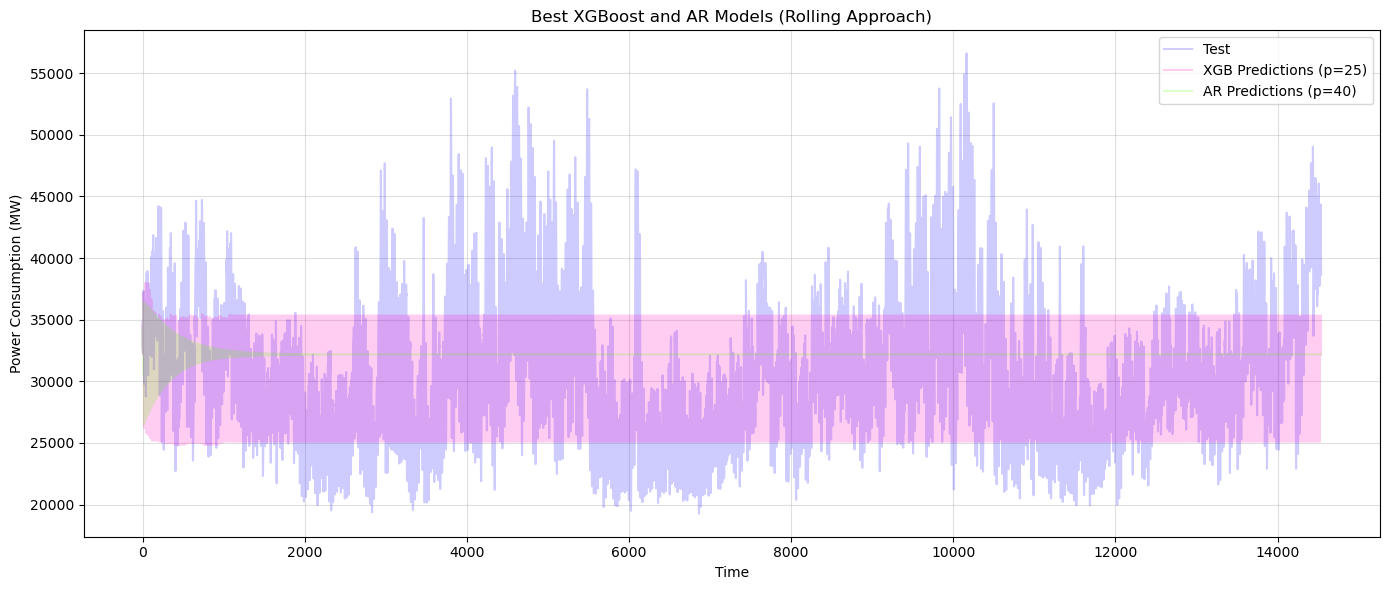

In [10]:
plot_best_rolling(results_rolling)

### 5.2 Up-to-date Approach

In [11]:
results_uptodate = find_best_model_uptodate(
    dataset=DATASET, 
    target=TARGET, 
    p_candidates=P_CANDIDATES, 
    prop_test=TEST_PROP
)

Best XGB Model - Up-to-date (p=40)
MSE: 512248.6589
RMSE: 715.7155
MAE: 436.6352
R_squared: 0.9862

Best AR Model - Up-to-date (p=40)
MSE: 643015.8163
RMSE: 801.8827
MAE: 424.0543
R_squared: 0.9827

Overall Best Model: XGB with p=40 (MSE: 512248.6589)


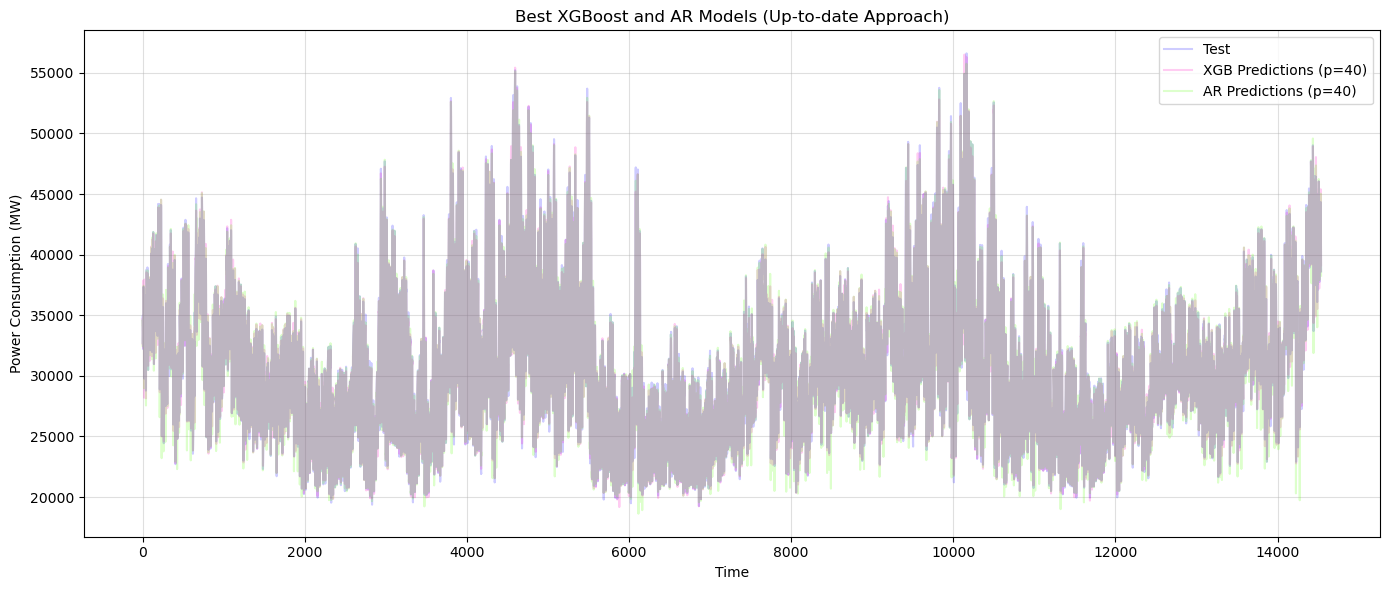

In [12]:
plot_best_uptodate(results_uptodate)